# Игры — Анализ рекламных источников

Цель: Анализ рекламных источников. Задача: Анализ поведения игроков в зависимости от источника перехода.
Описание датасетов:

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

Победа над первым врагом
Реализация проекта - разработка орбитальной сборки спутников
В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет game_actions.csv:

event_datetime — время события;
event — одно из трёх событий:
building — объект построен,
finished_stage_1 — первый уровень завершён,
project — проект завершён;
building_type — один из трёх типов здания:
assembly_shop — сборочный цех,
spaceport — космопорт,
research_center — исследовательский центр;
user_id — идентификатор пользователя;
project_type — тип реализованного проекта;
Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет ad_cost.csv:

day - день, в который был совершен клик по объявлению
source - источник трафика
cost - стоимость кликов
Датасет user_source.csv содержит колонки:

user_id - идентификатор пользователя
source - источников, с которого пришёл пользователь, установивший приложение




Декомпозиция:
1. Предобработка данных    
    1.1 Чтение файлов    
    1.2 Работа с  наименованием колонок, пропусков, дубликатов, типов данных    
    1.3 Проверка и работа с аномальными значениями    
    1.4 Вывод    
2. Исследовательский анализ данных    
    2.1 Анализ событий пользователей во времени    
    2.2 Составление портрета пользователя. Анализ событий пользователей и типов реализованного проекта во времени с разбивкой по источникам   
    2.3 Маркетинг. Затраты на рекламу. Стоимость привлечения пользователя. Конверсия.      
    2.4 Вывод    
3. Проверка гипотез    
    3.1 Время завершения уровня различается в зависимости способа прохождения:   
    - *через реализацию проекта,*    
    - *через победу над первым игроком.*    
    3.2 Переход на второй уровень зависит от источника привлечения    
    3.3 Вывод    
4. Итоги     
5. Презентация    

## Извлечение данных и предобработка.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
import datetime as dt
import math as mth
from scipy import stats as st
from datetime import datetime, timedelta
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

# код для отображения 200 столбцов в датасетах
pd.options.display.max_columns = 200
# отображение строчек без усечений
pd.options.display.max_colwidth = 150

In [2]:
game_actions =  pd.read_csv('/datasets/game_actions.csv', sep=',')
user_source =  pd.read_csv('/datasets/user_source.csv', sep=',')
ad_costs =  pd.read_csv('/datasets/ad_costs.csv', sep=',')

### Предообработка game_actions

In [3]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


Можем увидеть, что есть пропуски, неверный тип данных у даты

In [4]:
# выведим первые строки
game_actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [5]:
# посмотрим пропуски
game_actions.isna().sum()

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

In [6]:
# посмотрим уникальные значения в строках, где есть пропуски
game_actions['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

In [7]:
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [8]:
# выведим строки, где пропуски в project_type 
game_actions[game_actions['project_type'].isna()].tail()

,event_datetime,event,building_type,user_id,project_type
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN
135639,2020-06-05 12:32:49,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN


In [9]:
game_actions[game_actions['project_type'].isna()]['event'].unique() 

array(['building', 'finished_stage_1'], dtype=object)

В game_actions пропуски в том случае, если построен объект или завершен первый уровень, значит скорей всего завершен победой pvp. Поэтому данные пропуски можно заменить на pvp, у тех кто завершил первый уровень, а у тех кто нет пометить, что первый уровень.

In [10]:
# выведим строки, где пропуски в building_type 
game_actions[game_actions['building_type'].isna()].tail()

,event_datetime,event,building_type,user_id,project_type
135632,2020-06-04 15:50:38,finished_stage_1,NaN,22cce310-fe10-41a2-941b-9c3d63327fea,NaN
135633,2020-06-04 17:56:14,finished_stage_1,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN
135639,2020-06-05 12:32:49,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN


In [11]:
game_actions[game_actions['building_type'].isna()]['event'].unique() 

array(['finished_stage_1', 'project'], dtype=object)

В building_type пропуски в том случае, если построен завершен проект или завершен первый уровень, значит игрок перешел на второй уровень.

In [12]:
# проверка на дубликаты
game_actions.duplicated().sum()

1

In [13]:
# проверка на анамалии
game_actions.describe()

,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-08 22:30:04,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866


По первому датасету необходимо: 
- изменить тип данных 
- заменить пропуски   
- удалить дубликаты        
Аномальных значений не обнаружено.

In [14]:
# изменим тип данных и проверим
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
print(game_actions['event_datetime'].dtypes)

datetime64[ns]


In [15]:
# замена пропусков project_type
game_actions.loc[game_actions['project_type'].isna() & (game_actions['event'] == 'finished_stage_1'),
                                                                                  'project_type'] = 'pvp'
game_actions.loc[game_actions['project_type'].isna(), 'project_type'] = 'first_level'

In [16]:
game_actions['project_type'].value_counts()

first_level                   127957
pvp                             5817
satellite_orbital_assembly      1866
Name: project_type, dtype: int64

In [17]:
game_actions[game_actions['building_type'].isna()]['project_type'].unique()

array(['pvp', 'satellite_orbital_assembly'], dtype=object)

In [18]:
# замена пропусков building_type
game_actions['building_type'] = game_actions['building_type'].fillna('second_level')
game_actions['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14138
second_level        7683
Name: building_type, dtype: int64

In [19]:
# удаляем дубликаты
game_actions = game_actions.drop_duplicates()
game_actions.duplicated().sum()

0

In [20]:
# проверка
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   135639 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    135639 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.2+ MB


### Предообработка user_source и ad_costs

In [21]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


In [22]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [23]:
user_source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

In [24]:
user_source.duplicated().sum()

0

In [25]:
ad_costs

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


In [26]:
ad_costs.duplicated().sum()

0

Пропусков в этих датасетах не обнаружено, дубликатов и аномальных значений тоже не обнаружено. Необходимо только изменить тип данных у даты.

In [27]:
ad_costs['day'] = pd.to_datetime(ad_costs['day'])
print(ad_costs['day'].dtypes)

datetime64[ns]


### Вывод

В время предообработки данных мы проверили 3 датасета на пропуски, дубликаты, аномалии. Поработали с пропусками, удалили дубликаты и изменили тип данных. Теперь наши данные готовы для анализа

## Исследовательский анализ данных

### Анализ событий пользователей во времени

In [28]:
print("Количествово пользователей =", game_actions['user_id'].nunique())
print("Количествово событий =", game_actions['event'].count())

Количествово пользователей = 13576
Количествово событий = 135639


In [29]:
med = game_actions.groupby('user_id')['user_id'].count()
print("Среднее количество событий на пользователя -", med.median())

Среднее количество событий на пользователя - 10.0


In [30]:
# проверка дат
print(game_actions['event_datetime'].min())
print(game_actions['event_datetime'].max())

2020-05-04 00:00:01
2020-06-05 12:32:49


Text(0, 0.5, 'Кол-во событий')

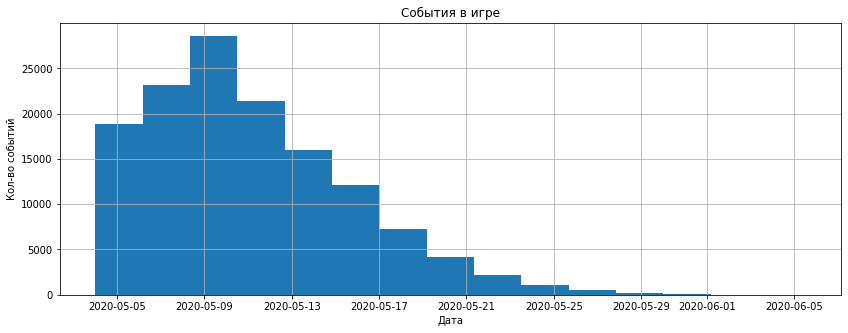

In [31]:
# построим гистограмму по дате
plt.figure(figsize=(14,5))
game_actions['event_datetime'].hist(bins=15)
plt.title('События в игре')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')

По графику видно, что пользователи были активны с 4 по 10 мая, поток в начале большой, но интересно, что с увеличением этой группы в течение месяца группа просто играющих резко сократилась. 

### Составление портрета пользователя. Анализ событий пользователей и типов реализованного проекта во времени с разбивкой по источникам 

In [32]:
# объединим 2 таблички
game_actions = game_actions.merge(user_source, how='left', on = 'user_id')
game_actions

,event_datetime,event,building_type,user_id,project_type,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,first_level,youtube_channel_reklama
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,first_level,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,first_level,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,first_level,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,first_level,yandex_direct
...,...,...,...,...,...,...
135634,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,first_level,instagram_new_adverts
135635,2020-06-05 02:25:12,finished_stage_1,second_level,515c1952-99aa-4bca-a7ea-d0449eb5385a,pvp,yandex_direct
135636,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,first_level,youtube_channel_reklama
135637,2020-06-05 12:12:27,finished_stage_1,second_level,32572adb-900f-4b5d-a453-1eb1e6d88d8b,pvp,facebook_ads


In [34]:
# распределение по источникам
sourse = game_actions.groupby('source').agg({'user_id':'nunique'}).reset_index().rename(columns={'user_id':'users'})
sourse

,source,users
0,facebook_ads,2726
1,instagram_new_adverts,3347
2,yandex_direct,4817
3,youtube_channel_reklama,2686


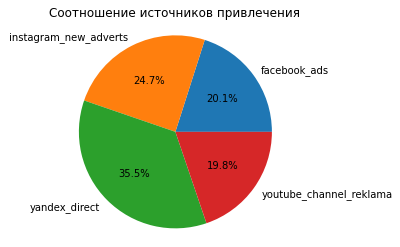

In [35]:
# распределение в виде диграммы
fig, ax = plt.subplots()
ax.pie(sourse['users'],
       labels=sourse['source'],
       autopct='%1.1f%%')
ax.axis("equal")
plt.title("Соотношение источников привлечения")
plt.show()

In [36]:
# посмотрим распределение по источникам тех, кто завершил 1 уровень.
sourse_level_2 = game_actions[game_actions['event'] == 'finished_stage_1'].groupby('source').agg({'user_id':'nunique'}).reset_index().rename(columns={'user_id':'users_end_level_1'})
sourse_level_2['users_all'] = sourse['users']
sourse_level_2['users_path'] = sourse_level_2['users_end_level_1']/sourse_level_2['users_all']
sourse_level_2 

,source,users_end_level_1,users_all,users_path
0,facebook_ads,1150,2726,0.421864
1,instagram_new_adverts,1466,3347,0.438004
2,yandex_direct,2042,4817,0.423915
3,youtube_channel_reklama,1159,2686,0.431497


Более менее одинаковое распределение источников среди тех, кто завершил первый уровень. Но чаще всего пользователи из instagram_new_adverts завершают чаще.

In [37]:
# посмотрим долю тех, кто за это время завершил игру
level_end = (game_actions[game_actions['event'] == 'finished_stage_1']['user_id'].nunique()/game_actions['user_id'].nunique())

42.85% пользователей закончили первый уровень.

In [38]:
past_players = game_actions[game_actions['project_type'] != 'first_level']['user_id']
passed_time = (game_actions
              .query('user_id in @past_players')
              .groupby('user_id')
              .agg({'event_datetime':['min','max']}))
passed_time['level_time'] = passed_time[('event_datetime', 'max')] - passed_time[('event_datetime', 'min')]
passed_time.columns = passed_time.columns.droplevel(1)
passed_time = passed_time.reset_index().sort_values(by='level_time')
passed_time.head(10)

,user_id,event_datetime,event_datetime,level_time
91,03990bc0-47b6-44ce-9f8b-3afb1a97d0e7,2020-05-07 16:40:32,2020-05-08 02:19:33,0 days 09:39:01
4687,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04 00:13:21,2020-05-04 19:47:29,0 days 19:34:08
4547,c8180f71-68dc-4fd5-ba6e-ba5f5d0d28f7,2020-05-08 16:08:29,2020-05-09 11:52:33,0 days 19:44:04
825,2204ae7f-892b-494d-bd58-28816ff35eb5,2020-05-07 02:25:27,2020-05-08 01:02:51,0 days 22:37:24
1032,2ab1cc5a-413a-408e-ba76-01de8e12bead,2020-05-05 13:25:04,2020-05-06 13:43:12,1 days 00:18:08
689,1c472a67-3aac-43f1-994f-4afbbb564918,2020-05-08 03:52:35,2020-05-09 05:23:00,1 days 01:30:25
2002,56758e22-1604-47ed-9cd2-b2cc73eea47f,2020-05-06 10:22:51,2020-05-07 12:48:56,1 days 02:26:05
2556,70db22b3-c2f4-43bc-94ea-51c8d2904a29,2020-05-04 13:41:55,2020-05-05 18:54:37,1 days 05:12:42
841,22b2aade-2741-4cd7-aafa-8da404e7b730,2020-05-07 10:30:52,2020-05-08 17:16:15,1 days 06:45:23
2531,6ff3138b-b242-4ec3-b50f-8d6f999c0848,2020-05-09 18:23:09,2020-05-11 02:52:22,1 days 08:29:13


In [39]:
passed_time['level_time'].describe()

count                          5817
mean     11 days 20:37:59.561801616
std       4 days 01:37:33.183162346
min                 0 days 09:39:01
25%                 9 days 05:13:21
50%                11 days 13:28:44
75%                14 days 05:15:16
max                30 days 21:58:53
Name: level_time, dtype: object

Минимум затраченный на прохождение первого уровня это 9 часов 39 минутю В среднем у игрока уходит почти 12 дней на прохождение уровня.

In [40]:
events = game_actions.groupby('event').agg({'building_type':'count'}).reset_index().rename(columns={'building_type':'count'})
events

,event,count
0,building,127956
1,finished_stage_1,5817
2,project,1866


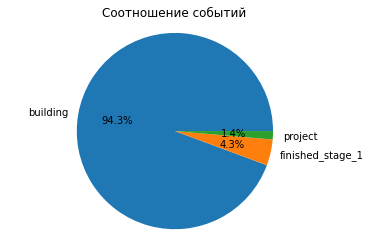

In [41]:
fig, ax = plt.subplots()
ax.pie(events['count'],
       labels=events['event'],
       autopct='%1.1f%%')
ax.axis("equal")
plt.title("Соотношение событий")
plt.show()

Самое частое событие в игре это постройки

In [42]:
# посмотрим что строят
builds = (game_actions[game_actions['building_type'] != 'second_level'].groupby('building_type')
          .agg({'event':'count'})
          .reset_index()
          .rename(columns={'event':'count'}))
builds

,building_type,count
0,assembly_shop,54494
1,research_center,14137
2,spaceport,59325


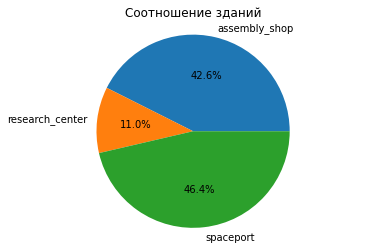

In [43]:
fig, ax = plt.subplots()
ax.pie(builds['count'],
       labels=builds['building_type'],
       autopct='%1.1f%%')
ax.axis("equal")
plt.title("Соотношение зданий")
plt.show()

Типы зданий: spaceport — космопорт - 46.4%, assembly_shop — сборочный цех - 42.6%, research_center — исследовательский центр - 11%.

In [44]:

# посмотрим за счет чего чаще всего проходят на второй уровень
project = (game_actions[game_actions['project_type'] != 'first_level'].groupby('project_type')
          .agg({'event':'count'})
          .reset_index()
          .rename(columns={'event':'count'}))
project

,project_type,count
0,pvp,5817
1,satellite_orbital_assembly,1866


Поведенческий портрет пользователя: это игрок, который пришел из яндекс директ или инстаграма, в среднем завершающий первый уровень почти за 12 дней, который в игре чаще всего строит здания: космопорты или сборочный цех. В среднем, совершающий по 10 действий. На следующий уровень переходит скорей всего за счет победы в pvp.

### Маркетинг. Затраты на рекламу. Стоимость привлечения пользователя. Конверсия. 

In [45]:
# пользователи по источникам
sourse = game_actions.groupby('source').agg({'user_id':'nunique'}).reset_index().rename(columns={'user_id':'users'})
sourse

,source,users
0,facebook_ads,2726
1,instagram_new_adverts,3347
2,yandex_direct,4817
3,youtube_channel_reklama,2686


In [46]:
# сумма затрат по источникам
sum_sources = (ad_costs
       .groupby('source')
       .agg({'cost':'sum'})         
       .reset_index()
       .rename(columns={'cost':'sum'}))
sum_sources

,source,sum
0,facebook_ads,2140.904643
1,instagram_new_adverts,2161.441691
2,yandex_direct,2233.111449
3,youtube_channel_reklama,1068.119204


In [47]:
# объединение и расчет средней стоимости клиента
sum_sources = sourse.merge(sum_sources, how ='left', on='source')
sum_sources['mean_cost'] = sum_sources['sum']/sum_sources['users']
sum_sources = sum_sources.round({'sum': 2, 'mean_cost': 2})
sum_sources

,source,users,sum,mean_cost
0,facebook_ads,2726,2140.90,0.79
1,instagram_new_adverts,3347,2161.44,0.65
2,yandex_direct,4817,2233.11,0.46
3,youtube_channel_reklama,2686,1068.12,0.40


In [48]:
# стоимость по дням
ad_costs_day = ad_costs.groupby('day').agg({'cost':'sum'}).reset_index().rename(columns={'cost':'sum'})
ad_costs_day

,day,sum
0,2020-05-03,3302.451840
1,2020-05-04,1865.004649
2,2020-05-05,1029.431469
3,2020-05-06,620.476519
4,2020-05-07,391.852033
5,2020-05-08,242.767553
6,2020-05-09,151.592924


До 9 Мая мы вкладывали в трафики по убыванию и в эти дни был сильный прирост по активности пользователей, после этого пользователи пошли на спад. Скорей всего от рекламы отказывать не надо, надо просто оптимизировать затраты на нее.  
Самый низкий по стоимости за клиента это youtube_channel_reklama, но с него и пришло всего 19,8% пользователей (самый низкий показатель). Самый высокий показатель по притоку показал Яндекс.Директ 35,5% и относительно дешевый 0,46 за пользователя. Самый дорогой источник это Фейсбук и привлекает он немного пользователей, поэтому от него явно стоит отказаться. Инстаграм второй по количеству привлеченных клиентов 24,7% и от него самый высокий процент тех, кто прошел 1-ый уровень(больше вовлечен в игру), но стоит он недешево. 
Стоит больше всего в рекламе сделать упор на: 
- Яндекс.Директ 
- небольшую долю закидывать на инстаграм (дорого, но эффективно) и ютуб (дешево, но небольшое количество)

### Вывод

Пользователи были активны с 4 по 10 мая, поток в начале большой, но интересно, что с увеличением этой группы в течение месяца группа просто играющих резко сократилась. скорей всего из-за прекращения рекламы. 43% пользователей закончили 1-ый уровень 
Поведенческий портрет пользователя: это игрок, который пришел из яндекс директ или инстаграма, в среднем завершающий первый уровень почти за 12 дней, который в игре чаще всего строит здания: космопорты или сборочный цех. В среднем, совершающий по 10 действий. На следующий уровень переходит скорей всего за счет победы в pvp.

До 9 Мая мы вкладывали в трафики по убыванию и в эти дни был сильный прирост по активности пользователей, после этого пользователи пошли на спад. Скорей всего от рекламы отказываться не надо, надо просто оптимизировать затраты на нее.  
Самый низкий по стоимости за клиента это youtube_channel_reklama, но с него и пришло всего 19,8% пользователей (самый низкий показатель). Самый высокий показатель по притоку показал Яндекс.Директ 35,5% и относительно дешевый 0,46 за пользователя. Самый дорогой источник это Фейсбук и привлекает он немного пользователей, поэтому от него явно стоит отказаться. Инстаграм второй по количеству привлеченных клиентов 24,7% и от него самый высокий процент тех, кто прошел 1-ый уровень(больше вовлечен в игру), но стоит он недешево. 
Стоит больше всего в рекламе сделать упор на: 
- Яндекс.Директ 
- небольшую долю закидывать на инстаграм (дорого, но эффективно) и ютуб (дешево, но небольшое количество)

## Проверка гипотез

### Проверка первой гипотезы

H0: Время завершения уровня не различается независимо от способа прохождения(через реализацию проекта и через победу над первым игроком)

H1: Время завершения уровня различается независимо от способа прохождения(через реализацию проекта и через победу над первым игроком)

Критический уровень значимости = 0.05

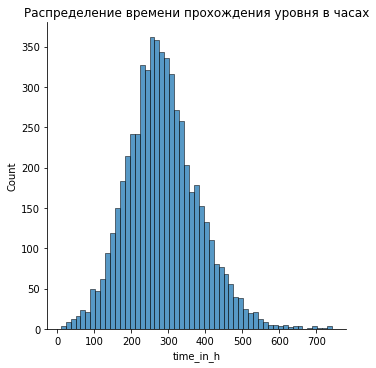

In [49]:
# берем таблицу, где уже считали время на прохождение добавляем столбец, что б перевести в часы и строим график распределения
passed_time['time_in_h'] = passed_time['level_time'] / np.timedelta64(1, 'h') #переводим затраченное время в часы
sns.displot(passed_time['time_in_h'])
plt.title("Распределение времени прохождения уровня в часах")
plt.show()

In [50]:
passed_time['time_in_h'].describe()

count    5817.000000
mean      284.633212
std        97.625884
min         9.650278
25%       221.222500
50%       277.478889
75%       341.254444
max       741.981389
Name: time_in_h, dtype: float64

<AxesSubplot:ylabel='time_in_h'>

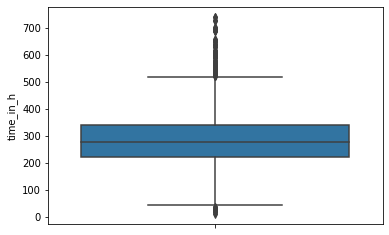

In [51]:
sns.boxplot(y=passed_time['time_in_h'])

In [52]:
passed_users = game_actions[(game_actions['project_type'] != 'first_level')][['user_id', 'project_type']]
project = game_actions[game_actions['project_type'] == 'satellite_orbital_assembly'][['user_id', 'project_type']]
finished_stage_1  = passed_users[~passed_users.isin(project['user_id'].unique())].dropna()

project_time = passed_time[['user_id', 'time_in_h']].merge(project, how='left', on='user_id').dropna()
pvp_time = passed_time[['user_id', 'time_in_h']].merge(finished_stage_1, how='left', on='user_id').dropna()

sample_1 = pvp_time['time_in_h']
sample_2 = project_time['time_in_h']

results = st.ttest_ind(
    sample_1, 
    sample_2, 
    equal_var=False)

alpha = 0.05
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print('Среднее время прохождения уровня через бой -', pvp_time.mean())
print('Среднее время прохождения уровня через строительство -', project_time.mean())   

p-значение: 5.708058235069386e-107
Отвергаем нулевую гипотезу
Среднее время прохождения уровня через бой - time_in_h    266.506688
dtype: float64
Среднее время прохождения уровня через строительство - time_in_h    323.013649
dtype: float64


Отвергаем нулевую гипотезу. 
Время прохождения зависит от способа прохождения. Среднее время, затрачиваемое на строительство 323 часа, а через пвп 267. Видно приходится ждать, когда закончится постройка исследования. В бою победить быстрее.

### Проверка второй гипотезы

H0 - источник привлечения не влияет на переход на второй уровень    
H1 - источник привлечения влияет на переход на второй уровень     
Критический уровень значимости = 0.05

In [53]:
sourse_level_2['users_level_1'] = sourse_level_2['users_all'] - sourse_level_2['users_end_level_1']
sourse_level_2

,source,users_end_level_1,users_all,users_path,users_level_1
0,facebook_ads,1150,2726,0.421864,1576
1,instagram_new_adverts,1466,3347,0.438004,1881
2,yandex_direct,2042,4817,0.423915,2775
3,youtube_channel_reklama,1159,2686,0.431497,1527


In [54]:
# функция с поправкой Бонферони
def z_test(group1, group2, alpha):
    for i in sourse_level_2.index:
        p1 = sourse_level_2[group1][i] / sourse_level_2['users_end_level_1'].sum()
        # пропорция успехов во второй группе:
        p2 = sourse_level_2[group2][i] / sourse_level_2['users_level_1'].sum()
        # пропорция успехов в комбинированном датасете:
        p_combined = ((sourse_level_2[group1][i] + sourse_level_2[group2][i]) / sourse_level_2['users_all'].sum())
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/sourse_level_2['users_end_level_1'].sum() + 1/sourse_level_2['users_level_1'].sum()))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(sourse_level_2['source'][i], p_value))
        if (p_value < alpha/4):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [55]:
z_test('users_end_level_1', 'users_level_1', 0.05)

facebook_ads p-значение: 0.43510581721087327
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

instagram_new_adverts p-значение: 0.19942268801334495
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

yandex_direct p-значение: 0.42576169341704606
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

youtube_channel_reklama p-значение: 0.7239873021953747
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Нулевую гипотезу не получилось опровергнуть. Источник привлечения не влияет на факт прохождения первого уровня.

### Выводы

Мы проверили 2 гипотезы: 
1. Влияет ли способ прохождения на время прохождения. Припроверке выяснилось, что влияет. Среднее время затраченное на постройку исследования выше , чем победа в pvp и составляет323 часа, в то время как pvp 267 часов. 

2. Влияет ли источник привлечения на факт прохождения первого уровня. При проверке выявили, что не влияет.

## Итоги 

Во время предообработки данных мы проверили 3 датасета на пропуски, дубликаты, аномалии. Поработали с пропусками, удалили дубликаты и изменили тип данных.
- Мы выявили, что пользователи были активны с 4 по 10 мая, поток в начале большой, но интересно, что с увеличением этой группы в течение месяца группа просто играющих резко сократилась. скорей всего из-за прекращения рекламы.    
- 43% пользователей закончили 1-ый уровень      
- **Поведенческий портрет пользователя:** это игрок, который пришел из яндекс директ или инстаграма, в среднем завершающий первый уровень почти за 12 дней, который в игре чаще всего строит здания: космопорты или сборочный цех. В среднем, совершающий по 10 действий. На следующий уровень переходит скорей всего за счет победы в pvp.

- До 9 Мая мы вкладывали в трафики по убыванию и в эти дни был сильный прирост по активности пользователей, после этого пользователи пошли на спад. Скорей всего от рекламы отказываться не надо, надо просто оптимизировать затраты на нее.    
- Самый низкий по стоимости за клиента это youtube_channel_reklama, но с него и пришло всего 19,8% пользователей (самый низкий показатель).      
- Самый высокий показатель по притоку показал Яндекс.Директ 35,5% и относительно дешевый 0,46 за пользователя.      
- Самый дорогой источник это Фейсбук и привлекает он немного пользователей, поэтому от него явно стоит отказаться.     
- Инстаграм второй по количеству привлеченных клиентов 24,7% и от него самый высокий процент тех, кто прошел 1-ый уровень(больше вовлечен в игру), но стоит он недешево. Стоит больше всего в рекламе сделать упор на:
    - Яндекс.Директ          
    - небольшую долю закидывать на инстаграм (дорого, но эффективно) и ютуб (дешево, но небольшое количество)       


А так же, Мы проверили 2 гипотезы: 
1. Влияет ли способ прохождения на время прохождения. Припроверке выяснилось, что влияет. Среднее время затраченное на постройку исследования выше , чем победа в pvp и составляет 323 часа, в то время как pvp 267 часов. 

2. Влияет ли источник привлечения на факт прохождения первого уровня. При проверке выявили, что не влияет.

**Рекомендации:**
- сделать постоянную отчетность по каналам, что бы смотреть на постоянной основе как трафик влияет на привлечение 
- переаспределить бюджет на рекламу и сделать его постоянным: сделать упро на Яндекс.Директе и Ютубе 
- для монетизации: сделать показ после боя 
- упросить постройку исследования орбитальной станции, что б сократить время на ее постройку.


## Презентация

Ссылка: https://disk.yandex.ru/i/eBUlxQ2VEoiwpg